In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Load and format

In [2]:
adata = sc.read_h5ad('/stanley/WangLab/kamal/data/technologies/starmap/atlas_final/split/well11.h5ad')

/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


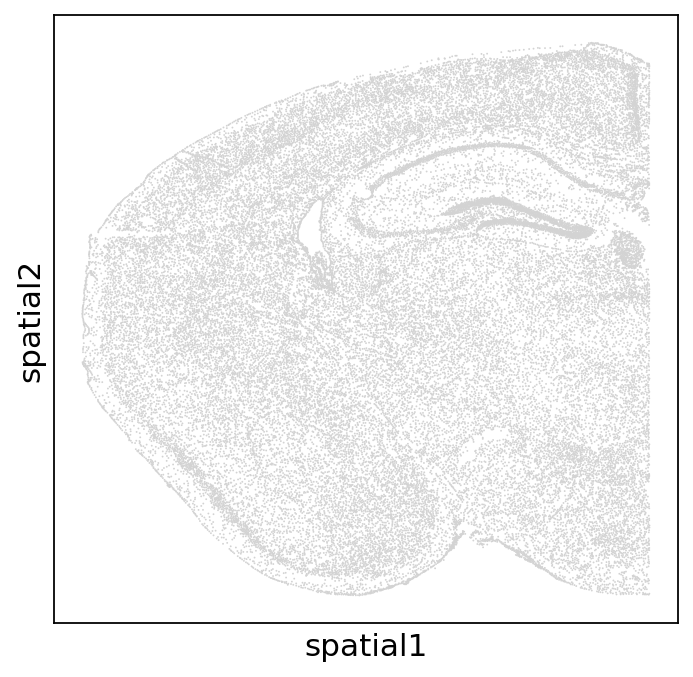

In [3]:
sc.set_figure_params(figsize=(5,5))
sc.pl.embedding(adata, basis='spatial')

In [4]:
adata.obsm['spatial'][:,0] *= -1

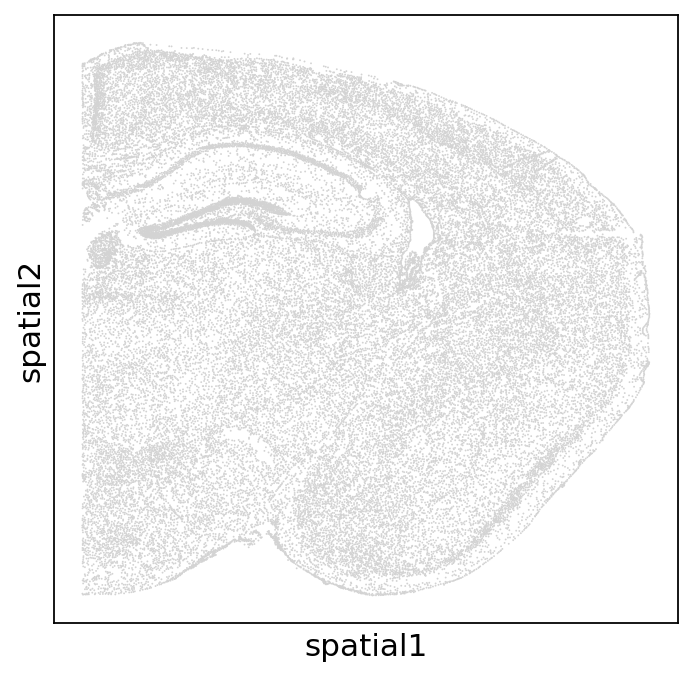

In [5]:
sc.pl.embedding(adata, basis='spatial')

In [6]:
adata

AnnData object with n_obs × n_vars = 43341 × 1021
    obs: 'orginindex', 'z', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'dataset', 'leiden', 'Rank1_Defined', 'Rank2_Defined', 'Rank3_Defined', 'Rank4_Defined', 'Rank1_Refine', 'Rank2_Refine', 'Rank3_Refine', 'Rank4_Refine', 'Rank5_Symbol', 'Rank5_Leiden_label', 'Tissue_leiden_id', 'Tissue_anatomical_label', 'Tissue_anatomical_parent_label', 'Tissue_final_label', 'Tissue_symbol', 'Tissue_description', 'Tissue_color', 'sample_s_c'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'

In [7]:
del adata.obs
coords = adata.obsm['spatial'].copy()
del adata.obsm
adata.obsm['spatial'] = coords

In [8]:
adata

AnnData object with n_obs × n_vars = 43341 × 1021
    obsm: 'spatial'

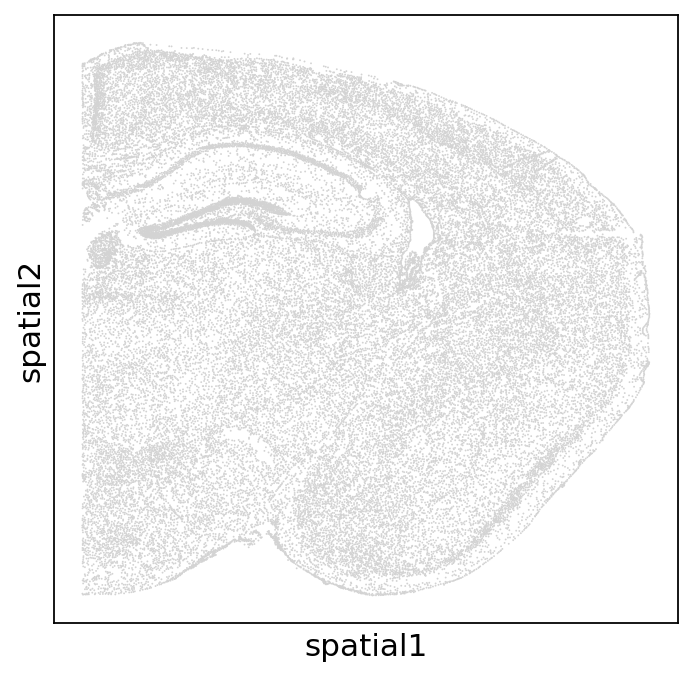

In [9]:
sc.pl.embedding(adata, basis='spatial')

In [10]:
# Get raw data
adata = adata.raw.to_adata()

In [11]:
# Normalize
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)

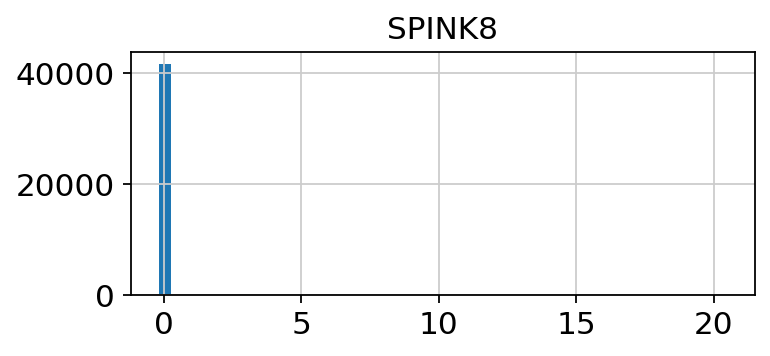

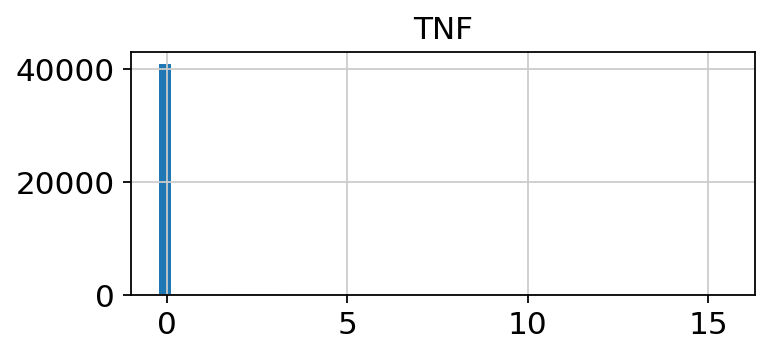

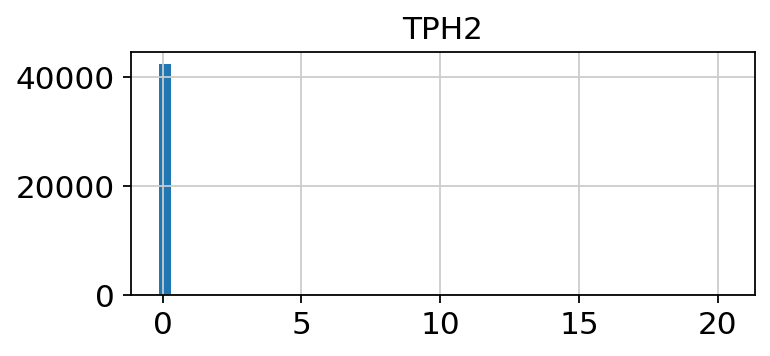

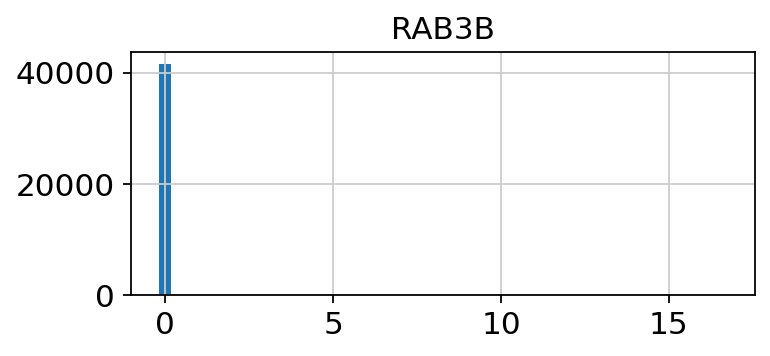

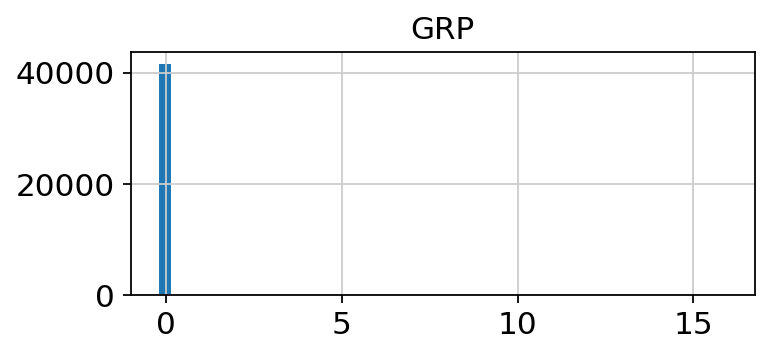

In [12]:
rand_idxs = np.random.choice(np.arange(adata.shape[1]), size=5, replace=False)
for i in rand_idxs:
    plt.figure(figsize=(5,2))
    plt.title(adata.var_names[i])
    plt.hist(adata.X[:,i], bins=50)
    plt.show()

# Cluster regions

In [13]:
def smooth(
    adata,
    k,
    subsample_rate,
    radius,
):

    # Get neighbor info
    if radius:
        nbrs = NearestNeighbors(radius=radius).fit(adata.obsm['spatial'])
        A = nbrs.radius_neighbors_graph()
    else:
        nbrs = NearestNeighbors(n_neighbors=k).fit(adata.obsm['spatial'])
        A = nbrs.kneighbors_graph()
    adata.obsp['spatial_connectivities'] = A.copy()

    # Subsample
    if subsample_rate:
        adata.obsp['spatial_connectivities_subsampled'] = A.copy()
        for i in range(len(adata)):
            nbr_idxs = adata.obsp['spatial_connectivities'][i].nonzero()[1]
            idxs_to_drop = np.random.choice(
                nbr_idxs,
                size=int(len(nbr_idxs)*(1-subsample_rate)),
                replace=False,
            )
            for j in idxs_to_drop:
                adata.obsp['spatial_connectivities_subsampled'][i,j] = 0
        adata.obsp['spatial_connectivities_subsampled'].eliminate_zeros()
    else:
        adata.obsp['spatial_connectivities_subsampled'] = np.eye(adata.shape[0])

    # Smooth
    adata.obsm['X_smoothed'] = adata.obsp['spatial_connectivities_subsampled'] @ adata.X

In [14]:
# Smooth
k = 50
subsample_rate = 1
radius = None

smooth(adata, k, subsample_rate, radius)

In [23]:
# PCA
n_pcs = 50
pca = PCA(n_components=n_pcs, random_state=2)
X_pca = pca.fit_transform(adata.obsm['X_smoothed'])

In [26]:
# K-means
n_clusters = 24
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
kmeans.fit(X_pca)
adata.obs['region_true'] = kmeans.labels_.astype(str)

/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


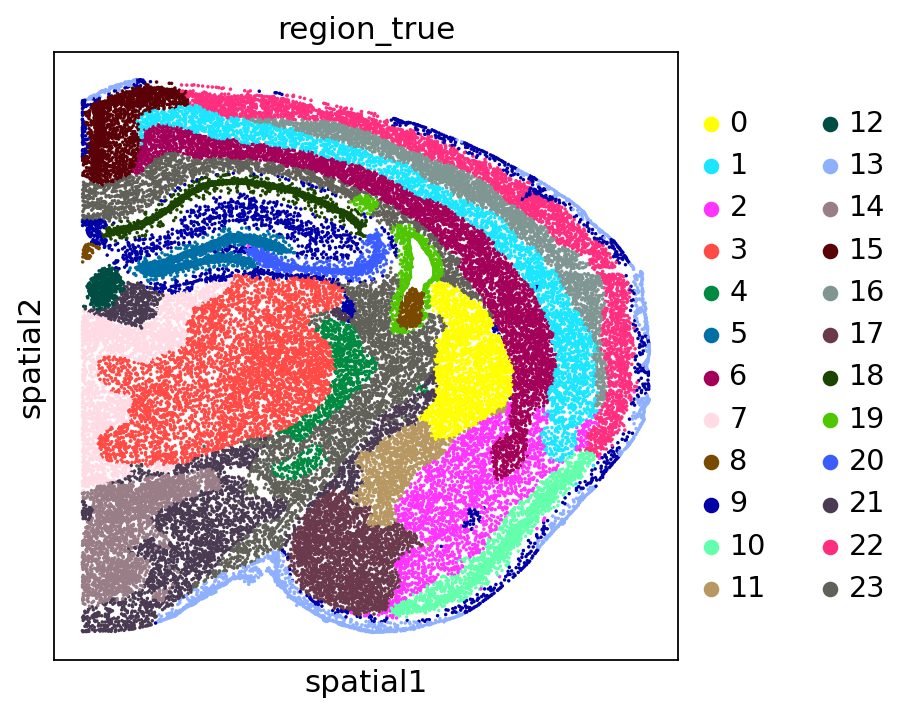

In [27]:
sc.pl.embedding(adata, basis='spatial', color='region_true', s=10, palette=sc.pl.palettes.default_102)

In [28]:
adata.write('/stanley/WangLab/kamal/data/projects/spin/reviews/brain/adata.h5ad')